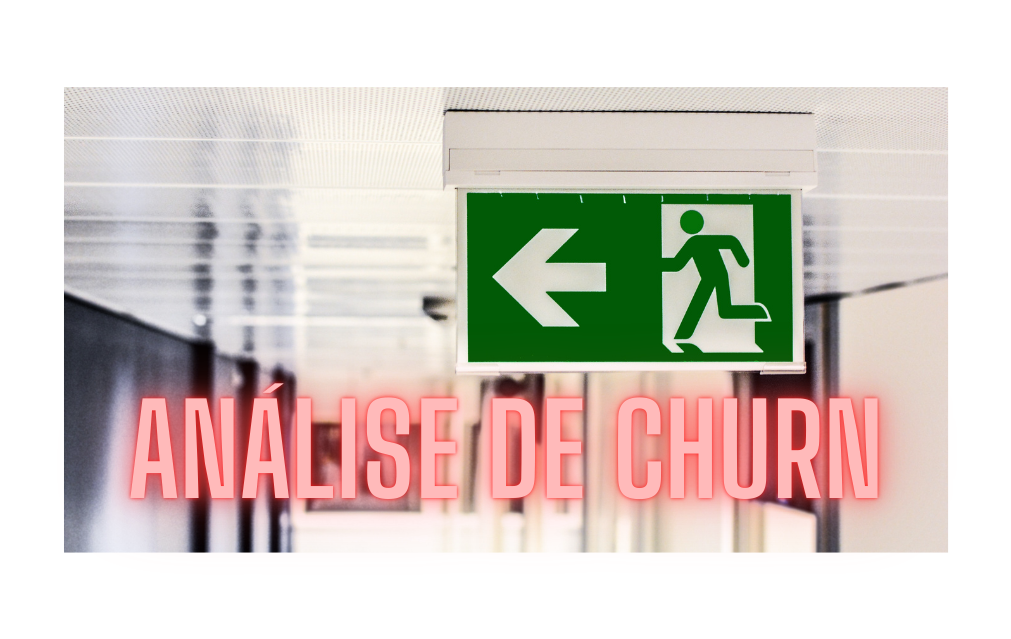

# Análise de Churn em Banco

Fonte: https://www.kaggle.com/datasets/santoshd3/bank-customers?resource=download
### O conjunto de dados contém informações sobre alguns clientes que estão encerrando suas contas no banco.


## **Variáveis:**

- **RowNumber**: número da linha.
- **CustomerId**: ID do cliente.
- **Surname**: sobrenome do cliente.
- **CreditScore**: score de crédito.
- **Geography**: país.
- **Gender**: gênero.
- **Age**: idade.
- **Tenure**: tempo de permanência.
- **Balance**: saldo em conta.
- **NumOfProducts**: número de produtos contratados com o banco.
- **HasCrCard**: possui ou não cartão de crédito (0 = 'não'; 1 = 'sim').
- **IsActiveMember**: é um membro ativo no banco (0 = 'não'; 1 = 'sim').
- **EstimatedSalary**: salário estimado/declarado.
- **Exited**: churn (0 = 'não'; 1 = 'sim').

In [ ]:
#importanto as bibliotecas
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# lendo o dataset
df = pd.read_csv('churn_modeling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**EDA:**

In [ ]:
# verificando quantas linhas e colunas temos no dataset
df.shape

(10000, 14)

In [ ]:
# removendo as colunas que não vamos utilizar
new_df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [ ]:
# verificando as informações do dataset e dando uma primeira olhada em valores
# nulos ou NAN
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [ ]:
# verificando se não temos de fato valores NA
new_df.isna().value_counts()

,,,,,,,,,,,count
CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,
False,False,False,False,False,False,False,False,False,False,False,10000


In [ ]:
# verificando se não temos de fato valores nulos
new_df.isnull().value_counts()

,,,,,,,,,,,count
CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,
False,False,False,False,False,False,False,False,False,False,False,10000


In [ ]:
# contando os valores de churn e não churn
new_df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


In [ ]:
# % dos valores de churn e não churn
churn = new_df['Exited'].value_counts(normalize = True)
print("Porcentagens de não churn e churn:")
for status, perc in churn.items():
    print(f"{status}: {perc * 100:.2f}%")

Porcentagens de não churn e churn:
0: 79.63%
1: 20.37%


In [ ]:
# verificando análise descritiva numérica do dataset
numerical_df = new_df.select_dtypes(include=np.number)
numerical_df.describe().round()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,651.0,39.0,5.0,76486.0,2.0,1.0,1.0,100090.0,0.0
std,97.0,10.0,3.0,62397.0,1.0,0.0,0.0,57510.0,0.0
min,350.0,18.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0
25%,584.0,32.0,3.0,0.0,1.0,0.0,0.0,51002.0,0.0
50%,652.0,37.0,5.0,97199.0,1.0,1.0,1.0,100194.0,0.0
75%,718.0,44.0,7.0,127644.0,2.0,1.0,1.0,149388.0,0.0
max,850.0,92.0,10.0,250898.0,4.0,1.0,1.0,199992.0,1.0


**Analisando visualmente variaveis categóricas:**

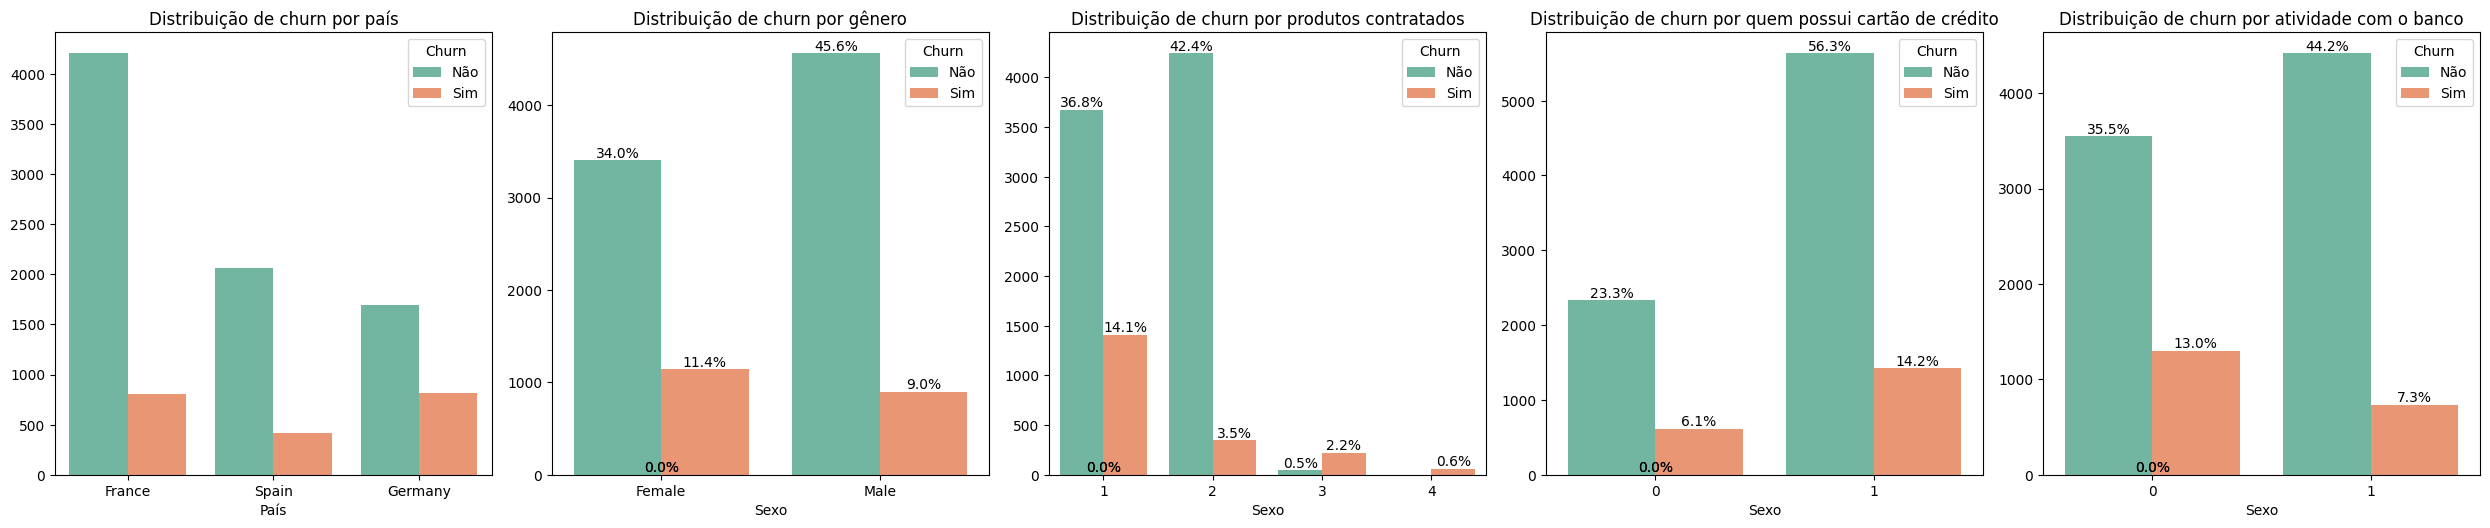

In [ ]:
# criando uma função para mostrar as %s em nossos gráficos
# afim de melhorar nossa interpretação.
def add_percentage (ax, total):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va ='bottom')

# iniciando a plotagem dos gráficos
# optei por deixá-los em uma única imagem para fácil extração dos mesmos
plt.figure(figsize=(25, 45))

plt.subplot(9, 5, 1)
ax1 = sns.countplot(data=new_df, x='Geography', hue='Exited', palette='Set2')
plt.title('Distribuição de churn por país')
plt.ylabel('')
plt.xlabel('País')
handles, labels = ax.get_legend_handles_labels()
ax1.legend(handles, ['Não', 'Sim'], title="Churn")
add_percentage(ax, len(new_df['Geography']))

plt.subplot(9, 5, 2)
ax2 = sns.countplot(data=new_df, x='Gender', hue='Exited', palette='Set2')
plt.title('Distribuição de churn por gênero')
plt.ylabel('')
plt.xlabel('Sexo')
handles, labels = ax.get_legend_handles_labels()
ax2.legend(handles, ['Não', 'Sim'], title="Churn")
add_percentage(ax2, len(new_df['Gender']))

plt.subplot(9, 5, 3)
ax3 = sns.countplot(data=new_df, x='NumOfProducts', hue='Exited', palette='Set2')
plt.title('Distribuição de churn por produtos contratados')
plt.ylabel('')
plt.xlabel('Sexo')
handles, labels = ax.get_legend_handles_labels()
ax3.legend(handles, ['Não', 'Sim'], title="Churn")
add_percentage(ax3, len(new_df['NumOfProducts']))

plt.subplot(9, 5, 4)
ax4 = sns.countplot(data=new_df, x='HasCrCard', hue='Exited', palette='Set2')
plt.title('Distribuição de churn por quem possui cartão de crédito')
plt.ylabel('')
plt.xlabel('Sexo')
handles, labels = ax.get_legend_handles_labels()
ax4.legend(handles, ['Não', 'Sim'], title="Churn")
add_percentage(ax4, len(new_df['HasCrCard']))

plt.subplot(9, 5, 5)
ax5 = sns.countplot(data=new_df, x='IsActiveMember', hue='Exited', palette='Set2')
plt.title('Distribuição de churn por atividade com o banco')
plt.ylabel('')
plt.xlabel('Sexo')
handles, labels = ax.get_legend_handles_labels()
ax5.legend(handles, ['Não', 'Sim'], title="Churn")
add_percentage(ax5, len(new_df['IsActiveMember']))

plt.tight_layout()
plt.show()



*   Maior número de clientes fiéis são da França, enquanto o churn francês e
alemão são os mesmos.
*   Maior churn é do sexo é feminino, enquanto a maior parte dos clientes fiés são do sexo masculino.
*   A contratação de 1 produto do banco representa o maior número de churn, enquanto a fidelização se dá com a contratação de 2 produtos. Enquanto temos o churn maior para a contratação de 3+ produtos. Será que os produtos não essenciais do banco são ruins?
*   Clientes com cartão de crédito possuem o maior churn e a maior fidelização quando comparado aos que não contratam o serviço de cartão de crédito.
*   Clientes mais ativos com o banco, tendem a não ter o churn elevado.


**Análise visual das variáveis contínuas:**

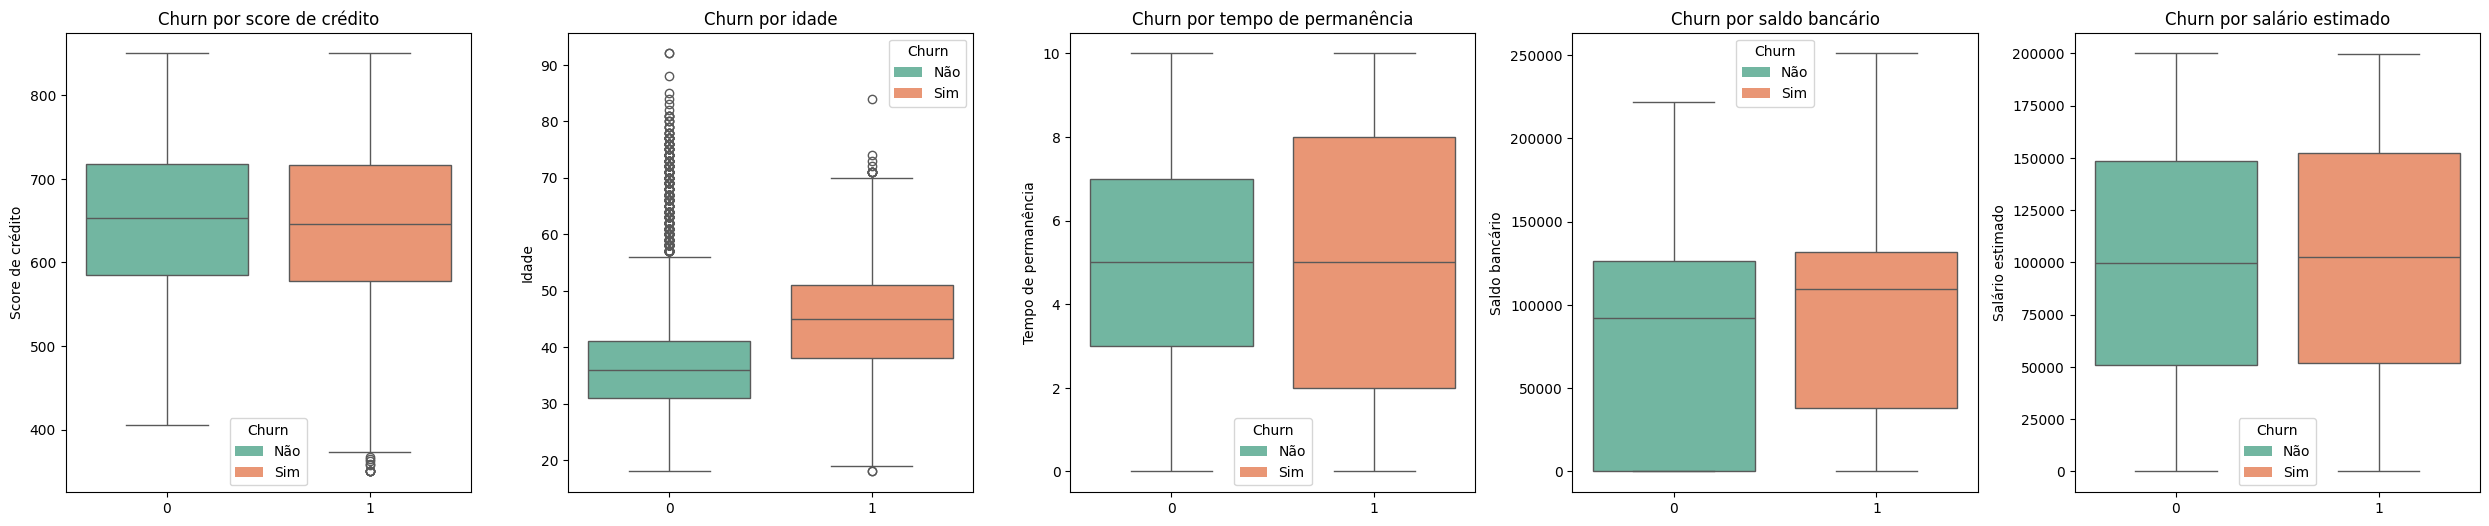

In [ ]:
# iniciando a plotagem dos gráficos
# optei por deixá-los em uma única imagem para fácil extração dos mesmos
plt.figure(figsize=(25, 45))

plt.subplot(9, 5, 1)
ax6 = sns.boxplot(data=new_df, x='Exited', y='CreditScore', hue='Exited', palette='Set2')
plt.title('Churn por score de crédito')
plt.ylabel('Score de crédito')
plt.xlabel('')
ax6.legend(handles, ['Não', 'Sim'], title="Churn")

plt.subplot(9, 5, 2)
ax7 = sns.boxplot(data=new_df, x='Exited', y='Age', hue='Exited', palette='Set2')
plt.title('Churn por idade')
plt.ylabel('Idade')
plt.xlabel('')
ax7.legend(handles, ['Não', 'Sim'], title="Churn")

plt.subplot(9, 5, 3)
ax8 = sns.boxplot(data=new_df, x='Exited', y='Tenure', hue='Exited', palette='Set2')
plt.title('Churn por tempo de permanência')
plt.ylabel('Tempo de permanência')
plt.xlabel('')
ax8.legend(handles, ['Não', 'Sim'], title="Churn")

plt.subplot(9, 5, 4)
ax9 = sns.boxplot(data=new_df, x='Exited', y='Balance', hue='Exited', palette='Set2')
plt.title('Churn por saldo bancário')
plt.ylabel('Saldo bancário')
plt.xlabel('')
ax9.legend(handles, ['Não', 'Sim'], title="Churn")

plt.subplot(9, 5, 5)
ax10 = sns.boxplot(data=new_df, x='Exited', y='EstimatedSalary', hue='Exited', palette='Set2')
plt.title('Churn por salário estimado')
plt.ylabel('Salário estimado')
plt.xlabel('')
ax10.legend(handles, ['Não', 'Sim'], title="Churn")

plt.tight_layout()
plt.show()


*   Nossa fidelização possui a mediana levemente superior a nossa média de churn.
*   Temos alguns outliers na linha de idade, mas são outliers que fazem sentido pois existem clientes de bancos de todas as idades, entretanto podemos tratar esses limites superiores e inferiores afim de averiguar de outras maneiras essas informações.

*   A mediana do tempo de permanência posssui o mesmo valor para clientes fidelizados e que realizaram churn.
*   Em relação a conta ancária, podemos observar que quem posui maiores saldos, tendem a realizar mais churn. Estamos deixando de oferecer rentabilidade para essas contas e por isso deixamos a desejar?

*   O churn por salário estimado possue quase a mesma mediana dos clientes fidelizados, mas ainda é um pouco superior.


**Tratando o modelo:**

Como temos ainda no new_df a variável categórica em string 'Geography' e 'Gender', vamos utilizar o LabelEncoder para a transformação em números referente aos países.

In [ ]:
country = new_df['Geography'].unique()
print(country)
country_count = new_df['Geography'].value_counts()
print(country_count)

['France' 'Spain' 'Germany']
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64


In [ ]:
label_encoder_Geography = LabelEncoder()
new_df['Geography'] = label_encoder_Geography.fit_transform(new_df['Geography'])
country = new_df['Geography'].unique()
print(country)
country_count = new_df['Geography'].value_counts()
print(country_count)

[0 2 1]
Geography
0    5014
1    2509
2    2477
Name: count, dtype: int64


Ficamos então com:
*   França: 0
*   Alemanha: 2
*   Espanha: 1





In [ ]:
gender = new_df['Gender'].unique()
print(gender)
gender_count = new_df['Gender'].value_counts()
print(gender_count)

['Female' 'Male']
Gender
Male      5457
Female    4543
Name: count, dtype: int64


In [ ]:
label_encoder_Gender = LabelEncoder()
new_df['Gender'] = label_encoder_Geography.fit_transform(new_df['Gender'])
gender = new_df['Gender'].unique()
print(gender)
gender_count = new_df['Gender'].value_counts()
print(gender_count)

[0 1]
Gender
1    5457
0    4543
Name: count, dtype: int64


Ficamos então com:
*   Homens: 1
*   Mulheres: 0

Iniciando o  modelo.

Trabalharemos com três algoritmos de Machine Learning afim de identificar a melhor acurácia.
Os algoritmos são:
- LinearRegression: Regressão Linear.
- RandomForest: Árvores de decisão.
- XGBoost: Árvores de decisão que tentam corrigir os erros das anteriores.

In [ ]:
#separando as variáveis
X = new_df.drop(columns=['Exited'])
y = new_df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#escalando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42,
                             use_label_encoder=False, eval_metric='logloss')}

#treinando e avaliar cada modelo
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Resultados para {name}:")
    print(f"Acurácia: {round(accuracy_score(y_test, y_pred) * 100, 2)}%")
    print(classification_report(y_test, y_pred))
    print("-" * 40)

Resultados para Logistic Regression:
Acurácia: 81.55%
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1607
           1       0.60      0.18      0.28       393

    accuracy                           0.82      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.82      0.77      2000

----------------------------------------
Resultados para Random Forest:
Acurácia: 86.45%
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.47      0.58       393

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000

----------------------------------------
Resultados para XGBoost:
Acurácia: 86.1%
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1607
           1

O modelo Random Forest apresentou o melhor desempenho geral para detectar churn com 86,45% de acurácia.